# Taks 1: Data scraping

### XJTLU
### Name: Rui Wang
### ID: 2033922 

In [1]:
# Libraries we use
import re
import time
import requests
import numpy as np
import pandas as pd
import urllib.parse # library to convert the query into url
from tqdm import tqdm  # Library to make progress bars
import seaborn as sns
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

%matplotlib inline

# Global constant urls
QUOTES_URL = 'http://quotes.toscrape.com'
GOODREADS_URL = 'https://www.goodreads.com'

def get_page_soup():
    """Scrape the website to get the access (urls) to all pages."""
    page_soups = []
    page_url = QUOTES_URL
    has_next_page_url = True
    
    while has_next_page_url:
        result = requests.get(page_url)
        result.encoding = 'utf-8'
        page_soup = BeautifulSoup(result.text, 'html.parser')
        page_soups.append(page_soup)
        try:
            page_url = f'{QUOTES_URL}{page_soup.find("li", class_ = "next").a["href"]}'
        except Exception as e:
            has_next_page_url = False
    return page_soups
        
def get_author_soup(page_soup):
    """Scrape page urls to get the access (urls) to details of authors."""
    author_soups = []
    author_urls = [f"{QUOTES_URL}{x['href']}" for x in page_soup.find_all("a", href = re.compile("/author/"))]
    
    for author_url in author_urls:
        result = requests.get(author_url)
        result.encoding = 'utf-8'
        author_soup = BeautifulSoup(result.text, 'html.parser')
        author_soups.append(author_soup)
    return author_soups
    
def scrape_quotes():
    """Scrape quotes with required attributes."""
    quotes_content, tags, author, birthday, country, description = [], [], [], [], [], []
    
    # Make a nice looking progress bar with tqdm and the context manager
    with tqdm(total = 100) as pbar:
        # Set the title of the progress bar
        pbar.set_description('Scraping quotes')
        # data scraping begins
        for page_soup in get_page_soup():
            # Quotes content
            quotes_content.extend([x.text for x in page_soup.find_all("span", class_ = "text")])
            # Tags
            tags.extend([x.meta['content'] for x in page_soup.find_all("div", class_ = "tags")])
            # Author
            author.extend([x.text for x in page_soup.find_all("small")])
            # scrape details from sub-hyper-linkings
            for author_soup in get_author_soup(page_soup):
                # Birthday of the author
                birthday.append(author_soup.find("span", class_ = "author-born-date").text)
                # Country of the author
                country.append(author_soup.find("span", class_ = "author-born-location").text.split(",")[-1].strip().replace("in ", ""))
                # Description of the author
                description.append(author_soup.find("div", class_ = "author-description").text.strip())
                # Update the progress bar manually
                pbar.update(1)
            
    scraped_data = pd.DataFrame({'Quotes_content': quotes_content,
                                 'Tags': tags,
                                 'Author': author,
                                 "Birthday_of_author": birthday,
                                 "Country_of_author": country,
                                 "Decription_of_author": description})
    return scraped_data

quotes_df = scrape_quotes()
quotes_df.head()

Scraping quotes: 100%|███████████████████████████████████████████████████████████████| 100/100 [01:53<00:00,  1.13s/it]


,Quotes_content,Tags,Author,Birthday_of_author,Country_of_author,Decription_of_author
0,“The world as we have created it is a process ...,"change,deep-thoughts,thinking,world",Albert Einstein,"March 14, 1879",Germany,"In 1879, Albert Einstein was born in Ulm, Germ..."
1,"“It is our choices, Harry, that show what we t...","abilities,choices",J.K. Rowling,"July 31, 1965",The United Kingdom,See also: Robert GalbraithAlthough she writes ...
2,“There are only two ways to live your life. On...,"inspirational,life,live,miracle,miracles",Albert Einstein,"March 14, 1879",Germany,"In 1879, Albert Einstein was born in Ulm, Germ..."
3,"“The person, be it gentleman or lady, who has ...","aliteracy,books,classic,humor",Jane Austen,"December 16, 1775",The United Kingdom,Jane Austen was an English novelist whose work...
4,"“Imperfection is beauty, madness is genius and...","be-yourself,inspirational",Marilyn Monroe,"June 01, 1926",The United States,Marilyn Monroe (born Norma Jeane Mortenson; Ju...


# Bonus

## Description of attributes

The [Goodreads](https://www.goodreads.com/) is an American social cataloging website and a subsidiary of Amazon that allows individuals to search its database of books, annotations, quotes, and reviews. So, we can scrape the quotes' and authors' information from this website. 

The first useful information is `likes of the quote`, which repesents how many people give their favors to a quote. Another useful information is `genre of the author`, that is the occupation of the author. In addition, `average rating of the author's books`, `votes for the author books`, `reviews for the author books` can embody the quality of the author's work. `Distinct books of the author` repesents the prolificacy for an author.

## Methods
In order to obtain those data from the website, we can use the API [Goodreads](https://www.goodreads.com/) provided for us, i.e, https://www.goodreads.com/quotes/search?utf8=%E2%9C%93&q={QUERY_CONTENT}&commit=Search， where **{QUERY_CONTENT}** is what we want to search at the website. Then, we just analyze the response, the HTML file, and study the tags with BeautifulSoup. With sufficient care and patience, we can find out all those attributes for all quotes and authors.

<font color=red, size=4> Search on the goodreads.com bases on the service of foregin proxy. If there is no such a proxy, find one and rectify the code with that proxy's configuration, otherwise this code will fail !!!<br><br> 
The headers and random time sleep are used to deal with the anti-crawler mechanism. </font>

In [2]:
# apply proxy to avoid firewall, launch the vpn or proxy before running this code
My_proxy = '127.0.0.1:19180' # change to your own proxy (ip:port)

proxies = {
    'http': f'http://{My_proxy}',
    'https': f'http://{My_proxy}', # this is rule of python 3.9, otherwise 'https://{My_proxy}' in other versions
}

# add headers to deal with the anti-crawler mechanism of the website, change to your own browser configuration
headers = {
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7',
    'Accept-Encoding': 'gzip, deflate, br',
    'Accept-Language': 'en,zh-CN;q=0.9,zh;q=0.8,en-GB;q=0.7,en-US;q=0.6',
    'Cache-Control': 'max-age=0',
    'Connection': 'keep-alive',
    'Cookie': 'ccsid=920-5520123-2437556; locale=en; __qca=P0-400153854-1698730476663; _session_id2=35d7149f9a1cd7b1f613cd2cb434f7c2; blocking_sign_in_interstitial=true',
    'Host': 'www.goodreads.com',
    'If-None-Match': 'W/"cbcac5d26d30a15f29d1472f02f2249c"',
    'Referer': 'http://quotes.toscrape.com/',
    'Sec-Ch-Ua': '"Chromium";v="118", "Microsoft Edge";v="118", "Not=A?Brand";v="99"',
    'Sec-Ch-Ua-Mobile': '?0',
    'Sec-Ch-Ua-Platform': '"Windows"',
    'Sec-Fetch-Dest': 'document',
    'Sec-Fetch-Mode': 'navigate',
    'Sec-Fetch-Site': 'cross-site',
    'Sec-Fetch-User': '?1',
    'Upgrade-Insecure-Requests': '1',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36 Edg/118.0.2088.76'
}

def query_goodreads(query):
    """Encode query, send the query and return the query soup from the goodreads.com/quotes/search."""
    # delete the "" of quote
    query = re.sub("“|”", "", query)
    # for easier search at goodreads
    if len(query) > 256: 
        query = query[:query[:256].rfind(",")]
    # encoding the query
    search_query = urllib.parse.quote(f'{query}')
    # the query_url for API to search
    search_url = f'https://www.goodreads.com/quotes/search?utf8=%E2%9C%93&q={search_query}&commit=Search'
    while True:
        try:
            result = requests.get(search_url, headers=headers, proxies=proxies, timeout=5)
            result.encoding = 'utf-8'
            if result.status_code == 200:
                soup = BeautifulSoup(result.text, 'html.parser')
                return soup
            print(f'Retry search on goodreads...{result.status_code}\n{search_url}\n')
            time.sleep(0.2 * random.random())
        except Exception as e:
            print(e)

def scrape_likes_of_quotes(quote_soup):
    """Scrape the number of likes for a specific quote with given quote soup."""
    # use the first searched quotes as the target (the most similar one) and return its number of likes
    return int(quote_soup.find("a", class_ = "smallText").text.split(' ')[0])

def scrape_author_details(author_soup):
    """Scrape the extra attributes of author for a specific author with given author soup."""
    # use the first searched author as the target (the most similar one)
    author_url = f'{GOODREADS_URL}{author_soup.find("a", class_ = "leftAlignedImage quoteAvatar", href = re.compile(f"/author/show/"))["href"]}'
    while True:
        try:
            result = requests.get(author_url, headers=headers, proxies=proxies, timeout=5)
            result.encoding = 'utf-8'
            if result.status_code == 200:
                soup = BeautifulSoup(result.text, 'html.parser')          
                # Genre of author
                Genre = "Undefined"
                item_list = [x.text for x in soup.find_all("div", class_ = "dataTitle")]
                if "Genre" in item_list:
                    Genre_index = item_list.index("Genre")
                    Genre = [x.text for x in soup.find_all("div", class_ = "dataItem")][Genre_index].strip()
                # Average rating of author's works
                Average_rating = float(soup.find("span", class_ = "average").text)
                # Total votes of author's works
                Vote = int(soup.find("span", itemprop = "ratingCount").text.strip().replace(",",''))
                # Total reviews of author's works
                Review = int(soup.find("span", itemprop = "reviewCount").text.strip().replace(",",''))
                # Total numbers of author's distinct works
                Distinct_work = int(soup.find_all("a", href = re.compile("/author/list"))[1].text.split(" ")[0].replace(",",''))
                return Genre, Average_rating, Vote, Review, Distinct_work
            print(f'Retry search on goodreads...{result.status_code}\n{search_url}\n')
            time.sleep(0.2 * random.random())
        except Exception as e:
            print(e)
    
def scrape_bonus(quotes_df):
        """Scrape those bonus for every quote and author in the given quote dataframe."""
        quotes, authors = quotes_df.Quotes_content, quotes_df.Author
        Numbers_of_likes_for_quote, Genres, Average_ratings, Votes, Reviews, Distinct_works = [], [], [], [], [], []
        
        # Make a nice looking progress bar with tqdm and the context manager
        with tqdm(total = 100) as pbar:
            # Set the title of the progress bar
            pbar.set_description('Scraping bonus')
            # data scraping begins
            for index in range(len(quotes)):
                Number_of_likes_for_quotes = scrape_likes_of_quotes(query_goodreads(quotes[index]))
                Genre, Average_rating, Vote, Review, Distinct_work = scrape_author_details(query_goodreads(authors[index]))
                
                Numbers_of_likes_for_quote.append(Number_of_likes_for_quotes)
                Genres.append(Genre)
                Average_ratings.append(Average_rating)
                Votes.append(Vote)
                Reviews.append(Review)
                Distinct_works.append(Distinct_work)
                # Update the progress bar manually
                pbar.update(1)
        
        quotes_df["Number_of_likes_for_quote"] = Numbers_of_likes_for_quote
        quotes_df["Genre"] = Genres
        quotes_df["Average_rating"] = Average_ratings
        quotes_df["Vote"] = Votes
        quotes_df["Review"] = Reviews
        quotes_df["Distinct_work"] = Distinct_works
        return quotes_df

quotes_df = scrape_bonus(quotes_df)
quotes_df.to_csv('./Rui_Wang_2033922.csv', index=False)
quotes_df.head()

Scraping bonus:  24%|███████████████▌                                                 | 24/100 [01:45<05:30,  4.35s/it]

HTTPSConnectionPool(host='www.goodreads.com', port=443): Read timed out. (read timeout=5)


Scraping bonus:  66%|██████████████████████████████████████████▉                      | 66/100 [05:14<02:54,  5.12s/it]

HTTPSConnectionPool(host='www.goodreads.com', port=443): Read timed out. (read timeout=5)


Scraping bonus: 100%|████████████████████████████████████████████████████████████████| 100/100 [07:59<00:00,  4.80s/it]


,Quotes_content,Tags,Author,Birthday_of_author,Country_of_author,Decription_of_author,Number_of_likes_for_quote,Genre,Average_rating,Vote,Review,Distinct_work
0,“The world as we have created it is a process ...,"change,deep-thoughts,thinking,world",Albert Einstein,"March 14, 1879",Germany,"In 1879, Albert Einstein was born in Ulm, Germ...",5437,"Science, Philosophy, Physics",4.07,47128,3129,840
1,"“It is our choices, Harry, that show what we t...","abilities,choices",J.K. Rowling,"July 31, 1965",The United Kingdom,See also: Robert GalbraithAlthough she writes ...,50651,"Fiction, Young Adult, Fantasy",4.46,34471882,769551,662
2,“There are only two ways to live your life. On...,"inspirational,life,live,miracle,miracles",Albert Einstein,"March 14, 1879",Germany,"In 1879, Albert Einstein was born in Ulm, Germ...",49363,"Science, Philosophy, Physics",4.07,47128,3129,840
3,"“The person, be it gentleman or lady, who has ...","aliteracy,books,classic,humor",Jane Austen,"December 16, 1775",The United Kingdom,Jane Austen was an English novelist whose work...,50812,"Fiction, Romance, Humor and Comedy",4.15,7895842,265151,3476
4,"“Imperfection is beauty, madness is genius and...","be-yourself,inspirational",Marilyn Monroe,"June 01, 1926",The United States,Marilyn Monroe (born Norma Jeane Mortenson; Ju...,49577,"Biographies & Memoirs, Nonfiction, Poetry",4.12,9213,1009,84


# Task 2

# Topic: How to find 10 most popular tags?

## Introduction
I want to select those **10 most popular tags**, which may be different from the **Top Ten Tags** in the [https://quotes.toscrape.com/](https://quotes.toscrape.com) website. From my point of view, the popular tags are such topics that are related to the number of `quotes`, `authors` and `likes`. The reason why I want to find 10 most popular tags is that I can catch those rife topics that most readers and authors envolve and discuss. Usually, more popular a tags is, more quotes, authors and average likes it will have, which can also reflect the degree of popularity of a tag.

## Methods
Based on those scarped data, we need firstly filter out those useful attributes, then calculate some specific data from those attributes. Finally, define a formula to establish a holistic evaluation to figure out 10 most popular tags.

In [3]:
quotes_df = pd.read_csv('./Rui_Wang_2033922.csv')
quotes_df.head()

,Quotes_content,Tags,Author,Birthday_of_author,Country_of_author,Decription_of_author,Number_of_likes_for_quote,Genre,Average_rating,Vote,Review,Distinct_work
0,“The world as we have created it is a process ...,"change,deep-thoughts,thinking,world",Albert Einstein,"March 14, 1879",Germany,"In 1879, Albert Einstein was born in Ulm, Germ...",5437,"Science, Philosophy, Physics",4.07,47128,3129,840
1,"“It is our choices, Harry, that show what we t...","abilities,choices",J.K. Rowling,"July 31, 1965",The United Kingdom,See also: Robert GalbraithAlthough she writes ...,50651,"Fiction, Young Adult, Fantasy",4.46,34471882,769551,662
2,“There are only two ways to live your life. On...,"inspirational,life,live,miracle,miracles",Albert Einstein,"March 14, 1879",Germany,"In 1879, Albert Einstein was born in Ulm, Germ...",49363,"Science, Philosophy, Physics",4.07,47128,3129,840
3,"“The person, be it gentleman or lady, who has ...","aliteracy,books,classic,humor",Jane Austen,"December 16, 1775",The United Kingdom,Jane Austen was an English novelist whose work...,50812,"Fiction, Romance, Humor and Comedy",4.15,7895842,265151,3476
4,"“Imperfection is beauty, madness is genius and...","be-yourself,inspirational",Marilyn Monroe,"June 01, 1926",The United States,Marilyn Monroe (born Norma Jeane Mortenson; Ju...,49577,"Biographies & Memoirs, Nonfiction, Poetry",4.12,9213,1009,84


### Filter the useful attributes out
In this DataFrame, `Birthday_of_author`, `Country_of_author`, `Description_of_author`,  `Genre` are useless as they are the attributes of authors. `Average_rating`, `Vote`, `Review`, `Distinct_work` are utilized in the analysis of the author's work rather than the performance of tags, thus these attributes are futile as well. Therefore, the attributes we are interested in are: `Tags`, `Quote_content`, `Author`, `Number_of_likes_for_quotes`.

In [4]:
popular_tags_df = quotes_df[['Tags', 'Quotes_content', 'Number_of_likes_for_quote', 'Author']]
popular_tags_df.head()

,Tags,Quotes_content,Number_of_likes_for_quote,Author
0,"change,deep-thoughts,thinking,world",“The world as we have created it is a process ...,5437,Albert Einstein
1,"abilities,choices","“It is our choices, Harry, that show what we t...",50651,J.K. Rowling
2,"inspirational,life,live,miracle,miracles",“There are only two ways to live your life. On...,49363,Albert Einstein
3,"aliteracy,books,classic,humor","“The person, be it gentleman or lady, who has ...",50812,Jane Austen
4,"be-yourself,inspirational","“Imperfection is beauty, madness is genius and...",49577,Marilyn Monroe


### Splite `Tags`
As the column `Tags` includes many different kinds of specific tags and ususlly a specific quote has more than one tag and author, which brings difficulty to analyze the performance of a particular tag, thus we should firstly split those tags. In addition, some quotes don't have defined tags, before starting the processing of spliting, label those undefined quotes with <font color=blue>"No tag"</font>.

In [5]:
# Replace the NAN with "No tag" for easy classification
popular_tags_df.loc[:,"Tags"] = popular_tags_df.loc[:,"Tags"].fillna("No tag")

split_df = pd.DataFrame()
for index in range(len(popular_tags_df["Tags"])):
    tags = popular_tags_df.loc[index, "Tags"].split(",")
    quote = popular_tags_df.loc[index, "Quotes_content"]
    number_of_likes = popular_tags_df.loc[index, "Number_of_likes_for_quote"]
    author = popular_tags_df.loc[index, "Author"]
    for tag in tags:
        split_df = pd.concat([split_df, pd.Series({'Tags': tag, 
                                                 'Quotes_content':quote, 
                                                 'Number_of_likes_for_quote':number_of_likes,
                                                 'Author':author})], axis=1, ignore_index=True)
popular_tags_df = split_df.T
popular_tags_df.head()

,Tags,Quotes_content,Number_of_likes_for_quote,Author
0,change,“The world as we have created it is a process ...,5437,Albert Einstein
1,deep-thoughts,“The world as we have created it is a process ...,5437,Albert Einstein
2,thinking,“The world as we have created it is a process ...,5437,Albert Einstein
3,world,“The world as we have created it is a process ...,5437,Albert Einstein
4,abilities,"“It is our choices, Harry, that show what we t...",50651,J.K. Rowling


### Group up and more attributes
Group up the dataframe with the key `tags`. As we want to estimate those popular tags according to number of **quotes** and **authors**, and the disturbance of **likes**, we also need to count `nb_Quotes`and `nb_Authors`, and list them in the form of list. To analyze the performance of **likes**, `sum_likes`, `avg_likes`, and `std_likes` are calculated. 

In [6]:
grouped_df = popular_tags_df.groupby('Tags')
popular_tags_df = pd.DataFrame()
for key, value in grouped_df: # just like a dictionary
    popular_tags_df = pd.concat([popular_tags_df, pd.Series({'Tags': key, 
                                                       'nb_Quotes': len(value.Quotes_content),
                                                       'nb_Authors': len(np.unique(value.Author)),
                                                       'Likes': list(value.Number_of_likes_for_quote),
                                                       'sum_likes': np.sum(value.Number_of_likes_for_quote),
                                                       'avg_likes': round(np.mean(value.Number_of_likes_for_quote), 2),
                                                       'std_likes': round(np.std(value.Number_of_likes_for_quote), 2)
                                                      })], axis=1, ignore_index=True)

popular_tags_df = popular_tags_df.T
popular_tags_df.head()

,Tags,nb_Quotes,nb_Authors,Likes,sum_likes,avg_likes,std_likes
0,No tag,3,3,"[25325, 61558, 39]",86922,28974.0,25247.22
1,abilities,1,1,[50651],50651,50651.0,0.0
2,activism,1,1,[41379],41379,41379.0,0.0
3,adulthood,1,1,[6979],6979,6979.0,0.0
4,adventure,1,1,[17449],17449,17449.0,0.0


### Calculate the holistic score and find out 10 most popular tags

As we want to evluate the popular tags according to the number of qutoes and authors, along with the disturbtion of likes, so we define such a formula or `score` to give the calculate the holistic performance of tags. <br> <br>

<center> 
    <font size=3>
    $score = \alpha · nb\_Quotes + \beta · nb\_Authors + \gamma · log_{10}(avg\_likes + 1) - \theta· log_{10}(std\_likes + 1),$
    </font>
</center>

<br>where $\alpha = 0.25$, $\beta = 0.25$, $\gamma = 0.4$, and $\theta = 1 - \alpha - \beta - \gamma = 0.1$

In [7]:
alpha, beta, gamma = 0.25, 0.25, 0.4
theta = 1 - alpha - beta - gamma

score = alpha*np.array(popular_tags_df.nb_Quotes) + beta*np.array(popular_tags_df.nb_Authors) + gamma*np.log10((np.array(popular_tags_df.avg_likes) + 1).astype('float')) - theta*np.log10((np.array(popular_tags_df.std_likes) + 1).astype('float'))
popular_tags_df.loc[:,"score"] = [round(x,2) for x in score]
most_popular_tags_df = popular_tags_df.sort_values(by="score", ascending=False).head(10)
most_popular_tags_df

,Tags,nb_Quotes,nb_Authors,Likes,sum_likes,avg_likes,std_likes,score
62,inspirational,13,12,"[49363, 49577, 41806, 32226, 41379, 25344, 333...",388831,29910.08,12696.79,7.63
77,love,14,11,"[60266, 32226, 28045, 41379, 41575, 39149, 214...",388632,27759.43,13414.17,7.61
72,life,13,11,"[49363, 60266, 32226, 38963, 46675, 43385, 257...",396404,30492.62,15972.14,7.37
57,humor,12,11,"[50812, 35178, 29974, 26341, 26685, 17763, 221...",291223,24268.58,10749.62,7.10
16,books,11,9,"[50812, 46675, 29644, 27566, 30516, 23462, 217...",302768,27524.36,11023.1,6.37
105,reading,7,7,"[23703, 26972, 34967, 27566, 21776, 18783, 20000]",173767,24823.86,5145.38,4.89
47,friendship,5,5,"[41575, 46675, 24084, 22526, 21277]",156137,31227.4,10690.69,3.89
46,friends,4,4,"[32226, 32127, 46675, 23462]",134490,33622.5,8333.52,3.42
125,truth,4,3,"[19647, 16110, 16415, 16062]",68234,17058.5,1500.59,3.13
136,writing,3,3,"[19301, 21776, 16960]",58037,19345.67,1966.38,2.89


## Data Visualization
Our data visulization will be implemented for the following four purposes. The sepcific graphs and utilized data will be interpreted in those examples.

1. Composition <br>

2. Distribution <br>

3. Relationship <br>

4. Comparsion <br>


### Composition —— Pie chart
In this section, we will compare the composition of quote and author within 10 most popular tags. From the figure, we can found that as the total number of author is less than the total number of quote, even a specific tag with the same number of quote and author will have a higher weight in author composition than in quote composition, such as `friendship` and `friend`. There is also an interesting example, `humor`, whose number of author is less than number of quote whereas its author weight is higher than its quote weight.

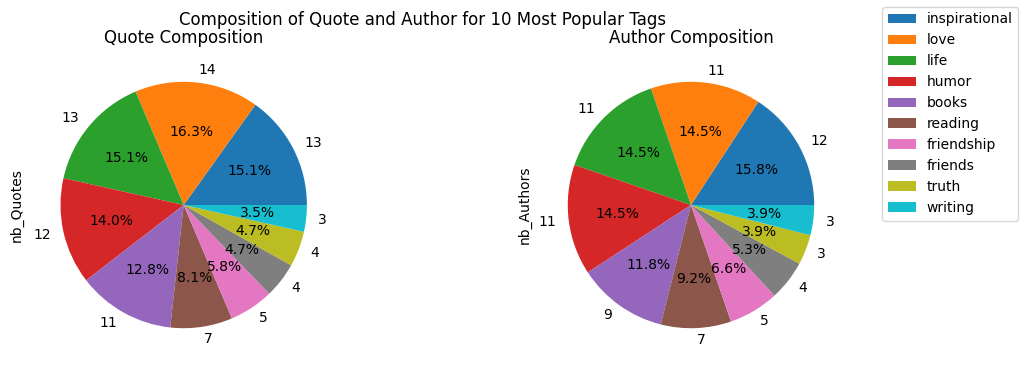

In [8]:
fig, axs = plt.subplots(1, 2, figsize = (12,4))
most_popular_tags_df.nb_Quotes.plot(kind="pie", ax=axs[0], labels=list(most_popular_tags_df.nb_Quotes), autopct='%1.1f%%')
most_popular_tags_df.nb_Authors.plot(kind="pie", ax=axs[1], labels=list(most_popular_tags_df.nb_Authors), autopct='%1.1f%%')
fig.legend(ncol=1, labels=list(most_popular_tags_df.Tags)) # ncol represents n columns
fig.suptitle("Composition of Quote and Author for 10 Most Popular Tags")
axs[0].set_title("Quote Composition", y=1)
axs[1].set_title("Author Composition", y=1);

### Distribution —— Histogram with KDE
In this section, we analyse the distributions of 10 most popular tags aganist quotes and authors in the form of histgoram and kernel density estimation (KDE). With the assistance of mean values, it is clear that both quotes and authors of 10 most popular  are scattered at the two regions, which are apart and symmetric against their means. This also leads few values to overlap their means. The mean quote is a little larger than the mean author, which corresponds to the fact that one author usually have more than one quote for a given tag.  

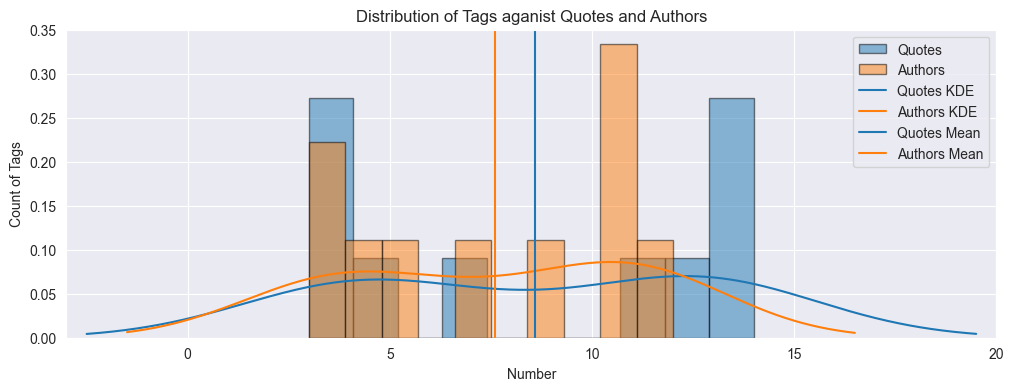

In [9]:
sns.set_style("darkgrid") # all the figures below will be darkgrid style

plt.figure(figsize=(12, 4))
most_popular_tags_df.nb_Quotes.plot(kind='hist', alpha = 0.5, color = sns.color_palette()[0], edgecolor = 'black', density = True, label = 'Quotes')
most_popular_tags_df.nb_Authors.plot(kind='hist', alpha = 0.5, color = sns.color_palette()[1], edgecolor = 'black', density = True, label = 'Authors')
most_popular_tags_df.nb_Quotes.plot(kind = 'kde', color = sns.color_palette()[0], label = 'Quotes KDE')
most_popular_tags_df.nb_Authors.plot(kind = 'kde', color = sns.color_palette()[1], label = 'Authors KDE')
plt.axvline(x=most_popular_tags_df.nb_Quotes.mean(), ymin=0, ymax=1, label = "Quotes Mean", color=sns.color_palette()[0])
plt.axvline(x=most_popular_tags_df.nb_Authors.mean(), ymin=0, ymax=1, label = "Authors Mean", color=sns.color_palette()[1])
plt.xlim(-3, 20)
plt.ylim([0, 0.35])
plt.xlabel("Number")
plt.ylabel("Count of Tags")
plt.title("Distribution of Tags aganist Quotes and Authors")
plt.legend();

### Distribution —— Bubble plot
In this section, we measure the relationship between tags and average likes, along with sum and standard deviation of likes in the form of bubble plot. From the plot, it can be found that although `truth` has smallest `avg_likes`, it does not become the tag whose score is lowest among 10 most popular tags under the criteria of our evaluation system. We can found `inspirational`which gets the highest score is not the tag whose `avg_likes`and `sum_likes` is largest, neither the tag with smallest `std_likes`.

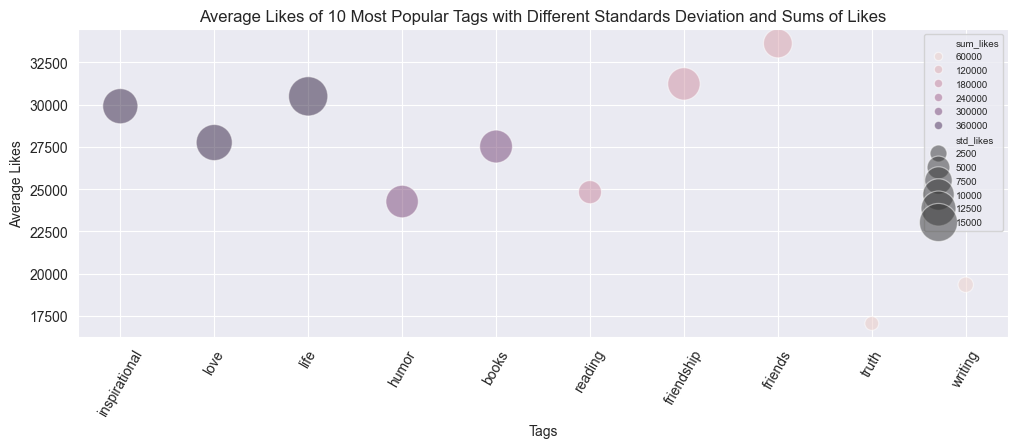

In [10]:
plt.figure(figsize=(12, 4))
sns.scatterplot(data=most_popular_tags_df, x="Tags", y="avg_likes", size="std_likes", hue="sum_likes", alpha=0.5, sizes=(100, 800))
plt.title('Average Likes of 10 Most Popular Tags with Different Standards Deviation and Sums of Likes')
plt.ylabel('Average Likes')
plt.xlabel('Tags')
plt.legend(prop={'size':7})
plt.xticks(rotation=60);

### Distribution —— Boxplot
We can use boxplot to analyze the **centre tendency**, **variance**, and **skewness** of the distribution of likes for 10 most popular tags. With respect to the **centre tendency**, which is defined as the position of the median line and box, we can find that `friends` has the highet distribution, and `truth` has the lowest distribution. In the aspect of **variance**, which is defined as the aggregate length of line and box, we can find that `life` has largest variance as its aggregate length of line and box is longest among 10 tags. We can also point out that `humor`, `books`, `friends` and `truth` may have some exceptional likes as there are **outliers** represented by bubbles in their boxplots. One interesting about the **skewness** is that almost all of the likes disturbances for 10 most popular tags are right skewed, as the median line is below than half of aggergate length of line and box. It seems that only `writing` has the symmetric distribution.

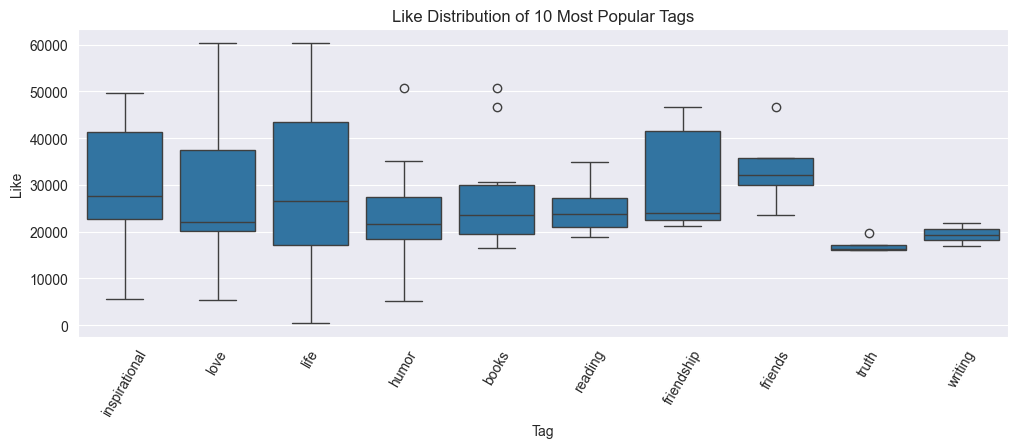

In [11]:
x_tags, y_likes = [], []
for tag, likes in zip(most_popular_tags_df.Tags, most_popular_tags_df.Likes):
    for like in likes:
        x_tags.append(tag)
        y_likes.append(like)
        
plt.figure(figsize=(12, 4))
sns.boxplot(x=x_tags, y=y_likes)
plt.title('Like Distribution of 10 Most Popular Tags')
plt.ylabel('Like')
plt.xlabel('Tag')
plt.xticks(rotation=60);

### Relationship —— heatmap
We can use the heatmap to analyze the correlation between `avg_likes`, `nb_Quotes`, `nb_Authors`. From the chart, we can find that the number of quotes and the number of authors have are high relevant. The average likes are less relevant with the number of quotes and the number of authors.

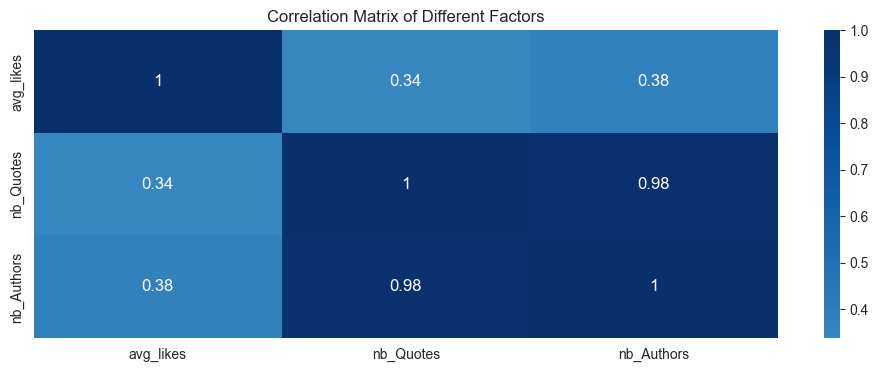

In [12]:
plt.figure(figsize=(12, 4))
sns.heatmap(most_popular_tags_df[['avg_likes', 'nb_Quotes', 'nb_Authors']].corr(),
            xticklabels=most_popular_tags_df[['avg_likes', 'nb_Quotes', 'nb_Authors']].corr().columns, 
            yticklabels=most_popular_tags_df[['avg_likes', 'nb_Quotes', 'nb_Authors']].columns,
            cmap='Blues',
            annot_kws={'size': 12},
            center=0,
            annot=True)
plt.title('Correlation Matrix of Different Factors');

### Comparison —— Barh chart
The score of values can be starightly obtained from the comparison of scores in the form of horizontal bar chart. One interest point is that the highest score and the second highest score are almost same, there are only 0.02 score discrepancies. Although the most popular tag in our estimation is `inspirational`, which ranks second at the Top Ten Tags in [Quote/scarpe](https://quotes.toscrape.com/) website, the total performance of our evaluation system is holistic and excellent enough.

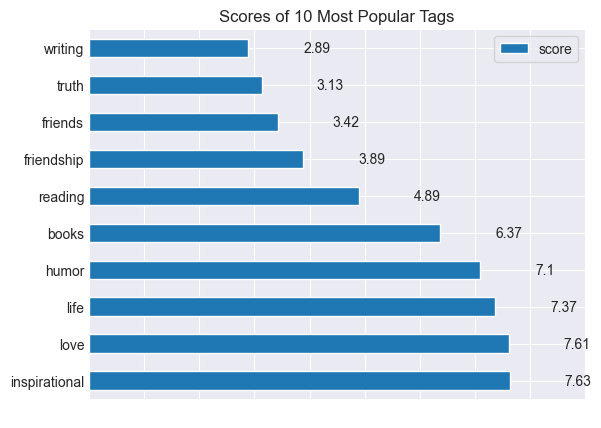

In [13]:
most_popular_tags_df[['Tags', 'score']].plot(kind="barh")
tags = most_popular_tags_df.Tags
scores = most_popular_tags_df.score
nums = np.arange(len(most_popular_tags_df))
for num, tag, score in zip(nums, tags, scores):
    plt.annotate(str(score), xy=(score + 1, num), va='center')
plt.grid(axis = 'x', color ='white', linestyle='-')
ax = plt.gca()
xt = plt.xticks()[0]
plt.xticks(xt, [' '] * len(xt))
plt.yticks(nums, tags)
ax.tick_params(axis='both', which='both',length=0)
sns.despine(left=True, bottom=True)
plt.title('Scores of 10 Most Popular Tags');

## Discussion and Conculsion

**The Top Ten Tags** exhibited in the [https://quotes.toscrape.com/](https://quotes.toscrape.com/) are: <br>
`love`, `inspirational`, `life`, `humor`, `books`, `reading`, `friendship`, `friends`, `truth`, `smile`

In our evaluation, **The 10 Most Popular Tags** are: <br>
`inspirational`, `love`, `life`, `humor`, `books`, `reading`, `friendship`, `friends`, `truth`, `writing`

Comparing with **The Top Ten Tags**, except the last tag `writing` in **The 10 Most Popular Tags**, which is different from the last one `smile` in **The Top Ten Tags**, both of the two rankings share the other 9 tags. In addition, the topest one in **The Top Ten Tags** is `love`, whereas **The 10 Most popular Tags** ranks `inspirational` as the leading tag.

Generally, it can be argued that our evaluation of popularity for tags is feasible and plausible.